# MF6 Project Problem Statement

A 300-ft thick aquifer is used for water supply.  The aquifer is also under consideration as a disposal field for treated waste water (aquifer-storage-recovery), where the filtration and dilution capacity of the aquifer will be used to receive the waste water for intentional re-use.

The figure below is a plan-view representation of a conceptual model of the aquifer. Each cell in the schematic is $1,500$ feet by $1,500$ feet.

![](aquiferplan.png)

The northern constant head boundary is set at h=600 ft. The southern edge constant boundary varies from 540 ft to 520 ft as one traverses from east to west.  Three water supply wells, W-1, W-2, and W-3 are already in service.  Hydrologic data suggests that the aquifer system has three distinct zones with different hydraulic characteristics.  These characteristics are tabulated below.

|Zone|K(cm/sec)|$n$|
|---|---:|---:|
|1|4.72|0.20|
|2|1.57|0.20|
|3|0.47|0.20|

The longitudinal dispersivity has been estimated as $\alpha_l=50~m$ and the transverse dispersivity has been estimated at $\alpha_t=20~m$.  The drinking water wells supply water at the rates tabulated below. 

|Well|Q(cfs)|
|---|---:|
|W-1|16.0|
|W-2|7.0|
|W-3|7.0|

The proposed re-use scheme will inject tracer-labeled waste-water into the aquifer into any of the three injection sites, I-1, I-2, or I-3.  The goal is for the concentration of the non-toxic tracer to never exceede 250 mg/L at the water production wells.  The tracer is added just before injection as a dilution indicator so that the water utility can shut down a well if the water in that well is not sufficiently diluted (much like the tracer added to natural gas to detect leaks).  The tracer concentration at the injection point is 1000 mg/L (the operation goal is the dilute the waste water four fold before it reaches the drinking water wells).

Determine using MF6 the answers to the questions below.  

1. Can 30 cfs of waste water be injected at I-3 and meet the water quality goal (4:1 dilution at drinking water wells)?
2. Is it possible to inject more waste water (higher flow or different location)?
3. Find the maximum volume that can be injected (at any or all of the three sites) and meet the water quality goal - this is the "regulatory assimilative capacity of the system."  Does this volume exceed the drinking water demand currently satisfied by the three wells?
4. Assume that instead of a non-toxic tracer, the injection water concentration represents some particular water quality parameter.  Assuming that the injection rate never exceedes the demand rate, what is the maximum waste load (mg/sec) that can be put into the aquifer and meet the raw water quality goal?



# Reverse-Engineered Transport Model

Here we reverse-engineer the entire model system so we can read from specific files prepared independently (circa 1960's style) so that the need for python skills are reduced (at the expense of file building)

## Workflow

The modeling workflow is:
1. Initial package set-up (Python package loading -- assume packages already installed in the kernel)
2. Read model structure data (I named the file "pr2-input-base.txt", you can rename as needed)
3. Read hydraulic conductivity array  
4. Read boundary array
5. Read idomain array
6. Read storativity array
7. Read porosity array
8. Read/generate wells (once per stress period)


In [131]:
%reset -f

In [132]:
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The script generates a lot of output that are suppressed by a `;`  Comment the character out to re-enable full output (which is damn helpful for debugging the script!)
:::

## Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [133]:
import os
import pathlib as pl
from pprint import pformat
import flopy
import git
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

:::{note}
The code block above loads various modules into the environment; they must exist and be loaded into the kernel - if not you get a warning "Module Not Found" and will have to install into the kernel (i.e. `pip -m install module`, or the `conda` equivalent
Filter warnings repeated to achieve "for sure ..." that the filter is applied.  By design the filter will not stop ERRORS, and warnings issued within functions will still display, but it will address one annoying deprecation error.
:::

### Define parameters

Define model units, spatial, and temporal discritization settings.

In [134]:
# Read control file
filename = "pr2-input-base.txt"
# Read the file
afile = open(filename,"r")  # connect and read file for base input
lines = []
for line in afile:
    lines.append(line.rstrip('\n'))
afile.close()
# Assign Properties
length_units= lines[0]
time_units= lines[1]
nlay = int(lines[2])  # Number of layers
nrow = int(lines[3])  # Number of rows
ncol = int(lines[4])  # Number of columns
delr = float(lines[5])  # Column width ($m$)
delc = float(lines[6])  # Row width ($m$)
delz = float(lines[7])  # Layer thickness ($m$)
top  = float(lines[8])  # Top of the model ($m$)

#

# more above

### Read Hydraulic Conductivity

Read the hydraulic conductivity array (float) arranged in layer,row, column format.  Read one times per model.

In [135]:
# Read hydraulic conductivity array
filename = "pr2-input-hydcond.txt"
hk = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        hk.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
hk = np.array(hk)

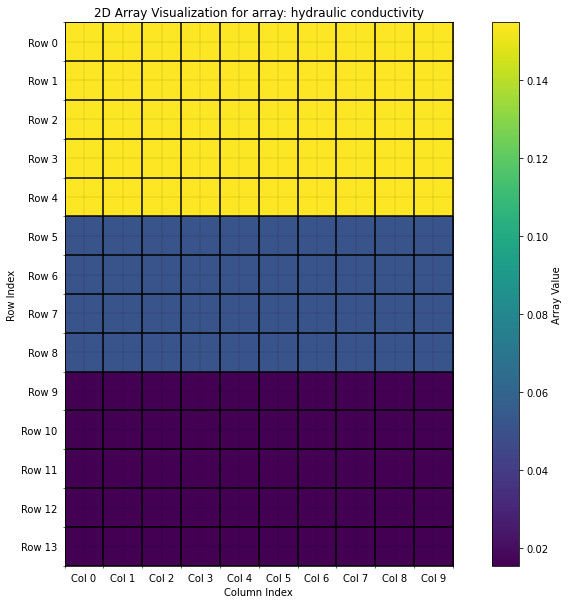

In [136]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = hk  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: hydraulic conductivity')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read Boundary Array

Read the boundary indication array (integer) arranged in layer,row, column format.  Read one times per model.

In [137]:
# Read boundary array
filename = "pr2-input-ibound.txt"
ibound = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        ibound.append([int(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
ibound = np.array(ibound)

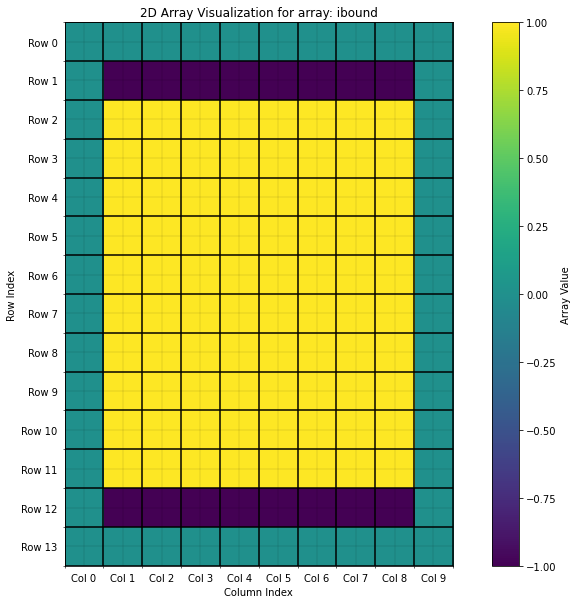

In [138]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = ibound  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: ibound')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read Computation Domain Array

Read the computation domain array (integer) indicating active/inactive cells arranged in layer,row, column format.  Read one times per model.

In [139]:
# Read idomain array
filename = "pr2-input-idomain.txt"
idomain = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        idomain.append([int(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
idomain = np.array(idomain)

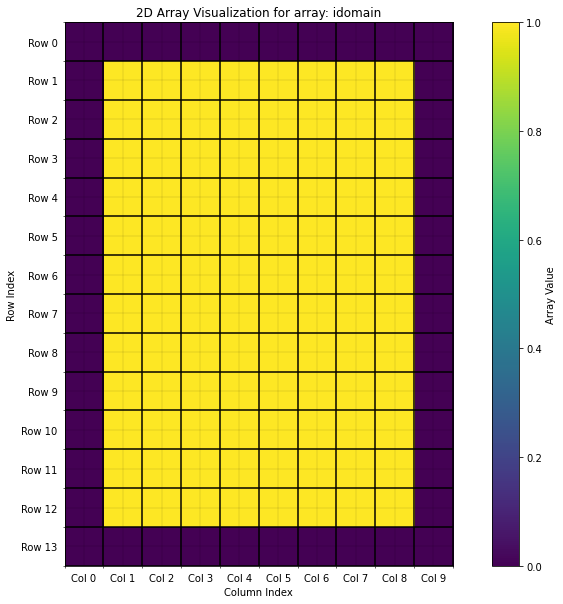

In [140]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = idomain  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: idomain')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read storage array

Read the storage coefficient array (float) arranged in layer,row, column format.  Read one times per model.

In [141]:
# Read storativity array
filename = "pr2-input-storage.txt"
ss_array = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        ss_array.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
ss_array = np.array(ss_array)

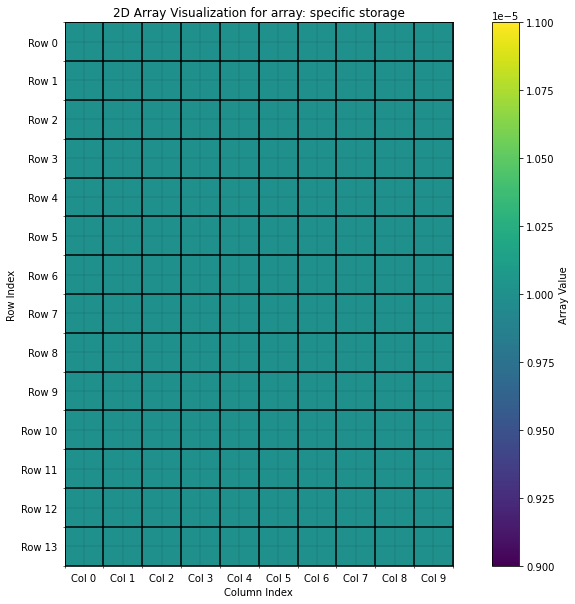

In [142]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = ss_array  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: specific storage')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read porosity array

Read theporosity array (float) arranged in layer, row, column format.  Read one times per model.

In [143]:
# Read porosity array
filename = "pr2-input-porosity.txt"
pors_array = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        pors_array.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
pors_array = np.array(pors_array)

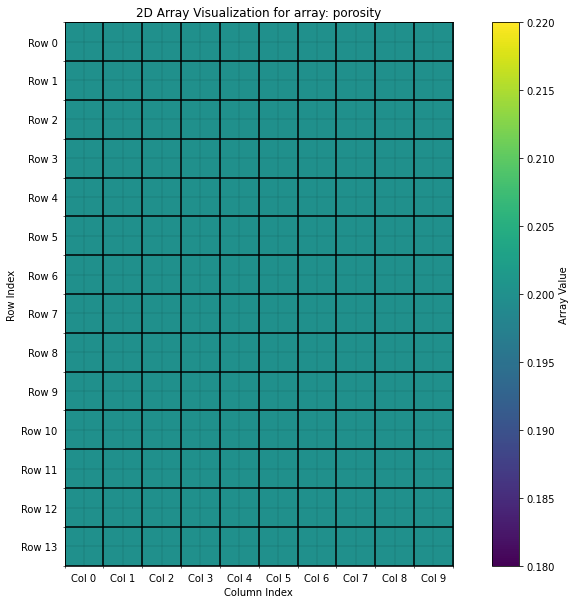

In [144]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = pors_array  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: porosity')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read longitudinal dispersivity array

Read the longitudinal dispersivity array (float) arranged in layer, row, column format.  Read one times per model.

In [145]:
# Read longitudinal dispersivity array
filename = "pr2-input-disperl.txt"
displ_array = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        displ_array.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
displ_array = np.array(displ_array)

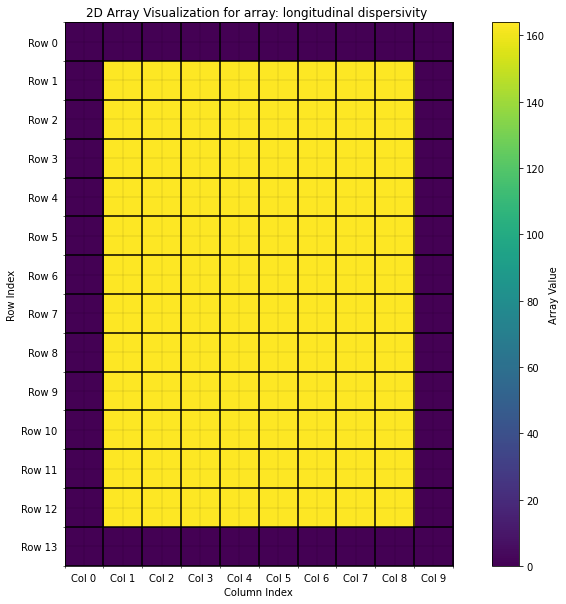

In [146]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = displ_array  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: longitudinal dispersivity ')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

### Read transverse dispersivity array 

Read the transverse dispersivity array (float) arranged in layer, row, column format.  Read one times per model.

In [147]:
# Read dispersivity in y-direction array
filename = "pr2-input-dispert.txt"
dispt_array = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        dispt_array.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
dispt_array = np.array(dispt_array)

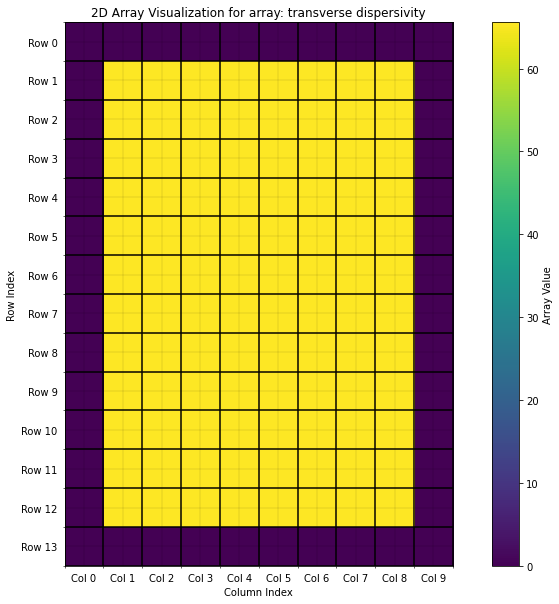

In [148]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = dispt_array  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: transverse dispersivity')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

In [149]:
# Read initial heads array
filename = "pr2-input-headinit.txt"
strt = []
# Read the file
afile = open(filename,"r")  # connect and read file for base input
for ilay in range(nlay):
    for line in afile:
        strt.append([float(n) for n in line.strip().split(',')])
afile.close()
# convert into numpy array
strt = np.array(strt)

strt

array([[9999.99 , 9999.99 , 9999.99 , 9999.99 , 9999.99 , 9999.99 ,
        9999.99 , 9999.99 , 9999.99 , 9999.99 ],
       [9999.99 ,  600.   ,  600.   ,  600.   ,  600.   ,  600.   ,
         600.   ,  600.   ,  600.   , 9999.99 ],
       [9999.99 ,  598.627,  598.635,  598.651,  598.671,  598.685,
         598.696,  598.698,  598.699, 9999.99 ],
       [9999.99 ,  597.244,  597.263,  597.299,  597.347,  597.373,
         597.4  ,  597.399,  597.398, 9999.99 ],
       [9999.99 ,  595.844,  595.873,  595.935,  596.046,  596.058,
         596.134,  596.1  ,  596.095, 9999.99 ],
       [9999.99 ,  592.981,  593.023,  593.102,  593.21 ,  593.295,
         593.388,  593.439,  593.477, 9999.99 ],
       [9999.99 ,  588.644,  588.707,  588.823,  588.976,  589.14 ,
         589.307,  589.46 ,  589.587, 9999.99 ],
       [9999.99 ,  584.245,  584.338,  584.507,  584.73 ,  584.981,
         585.242,  585.506,  585.823, 9999.99 ],
       [9999.99 ,  579.753,  579.891,  580.139,  580.457,  580.8

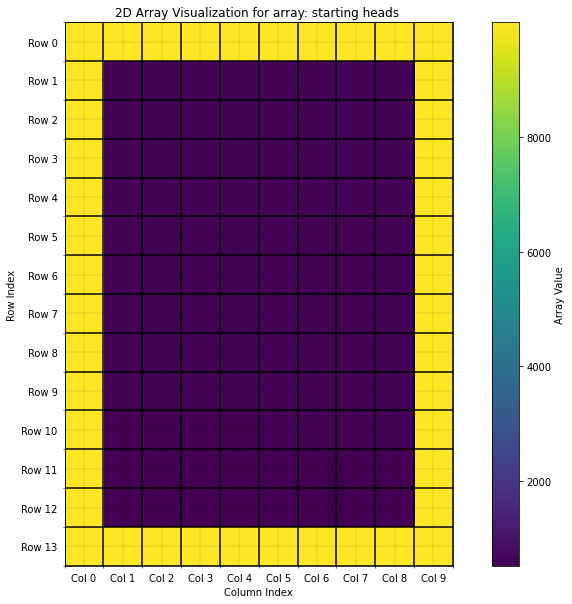

In [150]:
# Render the array into a visual representation - will repeat this code block as needed
import matplotlib.pyplot as plt
import numpy as np

# Example 2D array (you would replace this with your actual data)
# Assuming my_array2D is your 2D array (nrow x ncol)
my_array2D = strt  # Replace with your actual array

# Plot the 2D array using imshow
plt.figure(figsize=(14, 10))  # Optional: set the figure size
plt.imshow(my_array2D, cmap='viridis', interpolation='none')

# Add a colorbar to indicate the value scale
plt.colorbar(label='Array Value')
# Add the grid
plt.grid(visible=True, color='black', linestyle='-', linewidth=0.1)
# Customize the grid to align with the image cells
plt.gca().set_xticks(np.arange(-0.5, my_array2D.shape[1], 1), minor=True)
plt.gca().set_yticks(np.arange(-0.5, my_array2D.shape[0], 1), minor=True)
# Enable minor ticks to show the grid at each cell
plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=1.5)
# Disable the default major ticks
plt.gca().tick_params(which='major', bottom=False, left=False)
# Add row and column labels
rows, cols = my_array2D.shape
plt.xticks(np.arange(cols), labels=[f'Col {i}' for i in range(cols)])
plt.yticks(np.arange(rows), labels=[f'Row {i}' for i in range(rows)])

# Optional: Add labels for clarity
plt.title('2D Array Visualization for array: starting heads ')
plt.xlabel('Column Index')
plt.ylabel('Row Index')

# Display the plot
plt.show()

In [151]:
0.01548

0.01548

### Pumping and Injection Wells

Define wellfield settings, here we are using scripting to build the input structure, bou could just as well use a file read structure.

In [152]:
# Wellfield Conditions
# MF2K5 pumping/injection rates in length-time units
# CFS pumping is negative
qW1 = -16.0 
qW2 =  -7.0
qW3 =  -7.0
# CFS injection is positive
qI1 = 10.0 
qI2 = 10.0
qI3 = 10.0
# Concentrations 
# PPM pumping (set pumpings to zero value)
cW1 = 0.0
cW2 = 0.0
cW3 = 0.0
# PPM injection
cI1 = 1000.0
cI2 = 1000.0
cI3 = 1000.0
#spd = {
 #   0: [[0, 3, 6, cwell1, 2], [0, 10, 6, cwell0, 2]],
  #  1: [[0, 3, 6, cwell0, 2], [0, 10, 6, cwell0, 2]],
#}  # Well info 4 MT3D
# Build MF6 wellfield objects
wellist_sp1 = []
#                   (k,  i, j),   flow,  conc
wellist_sp1.append([(0, 4, 4), qI1, cI1])  # Injection well
wellist_sp1.append([(0, 4, 6), qI1, cI2])  # Injection well
wellist_sp1.append([(0, 7, 8), qI1, cI3])  # Injection well
wellist_sp1.append([(0, 11, 5), qW1, cW1])  # Pumping well
wellist_sp1.append([(0, 11, 7), qW2, cW2])  # Pumping well
wellist_sp1.append([(0, 11, 8), qW3, cW3])  # Pumping well
#
wellist_sp2 = []
#                   (k,  i, j),   flow,  conc
wellist_sp2.append([(0, 4, 4), qI1, cI1])  # Injection well
wellist_sp2.append([(0, 4, 6), qI2, cI2])  # Injection well
wellist_sp2.append([(0, 7, 8), qI3, cI3])  # Injection well
wellist_sp2.append([(0, 11, 5), qW1, cW1])  # Pumping well
wellist_sp2.append([(0, 11, 7), qW2, cW2])  # Pumping well
wellist_sp2.append([(0, 11, 8), qW3, cW3])  # Pumping well
#
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

### Define parameters

Define model units, spatial, and temporal discritization settings.

In [153]:
# Model units
#length_units = "meters"
#time_units = "seconds"

# Model parameters
#nlay = 1  # Number of layers
#nrow = 18  # Number of rows
#ncol = 14  # Number of columns
#delr = 100.0  # Column width ($m$)
#delc = 100.0  # Row width ($m$)
#delz = 10.0  # Layer thickness ($m$)
#top = 0.0  # Top of the model ($m$)
#prsity = 0.3  # Porosity - array reader above
k1 = 1.474e-4  # Horiz. hyd. conductivity of medium grain material ($m/sec$)
k2 = 1.474e-7  # Horiz. hyd. conductivity of fine grain material ($m/sec$)
inj = 0.001  # Injection well rate ($m^3/sec$)
ext = -0.0189  # Extraction well pumping rate ($m^3/sec$)
al = 20.0  # Longitudinal dispersivity ($m$)
trpt = 0.2  # Ratio of horiz. transverse to longitudinal dispersivity ($m$)
perlen = 2.0  # Simulation time ($years$)

# Additional model input
#hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)
#hk[:, 5:8, 1:8] = k2
laytyp = icelltype = 0

# Active model domain
#ibound = np.ones((nlay, nrow, ncol), dtype=int)
#ibound[0, 0, :] = -1
#ibound[0, -1, :] = -1
#idomain = np.ones((nlay, nrow, ncol), dtype=int)
icbund = 1

# Boundary conditions

# Transport related
sconc = 0.0
ath1 = al * trpt
dmcoef = 0.0  # m^2/s
# Time variables
perlen = [365.0 * 86400, 365.0 * 86400]
steady = [False, False]
nper = len(perlen)
nstp = [365, 365]
tsmult = [1.0, 1.0]
#
sconc = 0.0
c0 = 0.0
botm = [top - delz]
mixelm = -1

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0
percel = 1.0  # HMOC parameters
itrack = 2
wd = 0.5
dceps = 1.0e-5
nplane = 0
npl = 0
nph = 16
npmin = 2
npmax = 32
dchmoc = 1.0e-3
nlsink = nplane
npsink = nph
nadvfd = 1

## Model setup

Define functions to build models, write input files, and run the simulation.

**Groundwater Flow Package Build**

In [154]:
# Workspace and Executibles
binary = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6"  # location on MY computer of the compiled modflow program
workarea = "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mf6-pr2" # location on MY computer to store files this example (directory must already exist)
#workarea = workspace # location on MY computer to store files this example (directory must already exist)

# Set Simulation Name(s)
name = "mf6-pr2"
gwfname = "gwf-" + name
gwtname = "gwt-" + name

##### FLOPY Build simulation framework ####
sim = flopy.mf6.MFSimulation(
    sim_name="sim-" + name, exe_name=binary, version="mf6", sim_ws=workarea
)
####### CREATED "/home/sensei/ce-4363-webroot/ModflowExperimental/mf6-arm/mt3d_example9"

In [155]:
####### Instantiating MODFLOW 6 time discretization ########
tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units);
## delete ";" in above line at end to show full output

In [156]:
####### Instantiating MODFLOW 6 groundwater flow model ########
# Set Model Name (using same base name as the simulation)
model_nam_file = "{}.nam".format(gwfname)
# create MODFLOW6 flow model framework
gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True, model_nam_file=model_nam_file);
## delete ";" in above line at end to show full output

In [157]:
###### Instantiating MODFLOW 6 solver for flow model #######
# Set Iterative Model Solution (choose solver parameters)
# about IMS see: https://water.usgs.gov/nrp/gwsoftware/ModelMuse/Help/sms_sparse_matrix_solution_pac.htm
# using defaults see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfims.html
imsgwf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwfname}.ims",
    )
sim.register_ims_package(imsgwf, [gwf.name]);
## delete ";" in above line at end to show full output

In [158]:
###### Instantiating MODFLOW 6 discretization package ######
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwfname}.dis",
    );
## delete ";" in above line at end to show full output

In [159]:
# Build MF6 constant head boundaries:
xc = gwf.modelgrid.xcellcenters
chdspd = []
# Loop through the top & bottom sides.
for j in range(1,ncol-1):
#for j in np.arange(ncol):
#               l,  r, c,  head, conc
    chdspd.append([(0, 1, j), 600.0, 0.0])  # Top boundary
    hd = 520.0 + (xc[-1, j] - xc[-1, 1]) * 2.8572 / 1500
    chdspd.append([(0, 12, j), round(hd,1), 0.0])  # Bottom boundary
chdspd = {0: chdspd}

In [160]:
###### Instantiating MODFLOW 6 initial conditions package for flow model #######
flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic");
## delete ";" in above line at end to show full output

In [161]:
# Instantiating MODFLOW 6 node-property flow package
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=False,
    icelltype=icelltype,
    k=hk,
    k33=hk,
    save_specific_discharge=True,
    filename=f"{gwfname}.npf",
    );
## delete ";" in above line at end to show full output

In [162]:
# Define the Storage package (sto) with the ss array
#sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05)
sto = flopy.mf6.ModflowGwfsto(gwf, ss=ss_array);
## delete ";" in above line at end to show full output

In [163]:
# Instantiating MODFLOW 6 constant head package

flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chdspd),
    stress_period_data=chdspd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename=f"{gwfname}.chd",
    );
## delete ";" in above line at end to show full output

In [164]:
# Instantiate the wel package
flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=spd_mf6,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="WEL-1",
    filename=f"{gwfname}.wel",
    );
## delete ";" in above line at end to show full output

In [165]:
# Instantiating MODFLOW 6 output control package for flow model
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwfname}.hds",
    budget_filerecord=f"{gwfname}.bud",
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")],
    );
## delete ";" in above line at end to show full output



**Transport Package Building**

In [166]:
###### Instantiating MODFLOW 6 groundwater transport package ##########
gwtname = "gwt-" + name
gwt = flopy.mf6.MFModel(
    sim,
    model_type="gwt6",
    modelname=gwtname,
    model_nam_file=f"{gwtname}.nam",
    )#;
## delete ";" in above line at end to show full output
gwt.name_file.save_flows = True

In [167]:
# create iterative model solution and register the gwt model with it
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename=f"{gwtname}.ims",
    )
sim.register_ims_package(imsgwt, [gwt.name]);
## delete ";" in above line at end to show full output

In [168]:
###### Instantiating MODFLOW 6 transport discretization package #####
flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename=f"{gwtname}.dis",
    );
## delete ";" in above line at end to show full output

In [169]:
# Instantiating MODFLOW 6 transport initial concentrations
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic");
## delete ";" in above line at end to show full output

In [170]:
# Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv");
## delete ";" in above line at end to show full output

In [171]:
# Instantiating MODFLOW 6 transport dispersion package
if al != 0:
    flopy.mf6.ModflowGwtdsp(
        gwt,
        #alh=al, # longitudinal
        alh = displ_array,
        #ath1=ath1, # transverse
        ath1 = dispt_array,
        filename=f"{gwtname}.dsp",
        );
## delete ";" in above line at end to show full output

In [172]:
# Instantiating MODFLOW 6 transport mass storage package
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=pors_array,
##    porosity=prsity,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename=f"{gwtname}.mst",
    );
## delete ";" in above line at end to show full output

In [173]:
# Instantiating MODFLOW 6 transport source-sink mixing package
sourcerecarray = [
    ("WEL-1", "AUX", "CONCENTRATION"),
    ("CHD-1", "AUX", "CONCENTRATION"),
    ]
flopy.mf6.ModflowGwtssm(
    gwt,
    sources=sourcerecarray,
    print_flows=True,
    filename=f"{gwtname}.ssm",
    );
## delete ";" in above line at end to show full output

In [174]:
# Instantiating MODFLOW 6 transport output control package
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord=f"{gwtname}.cbc",
    concentration_filerecord=f"{gwtname}.ucn",
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
    filename=f"{gwtname}.oc",
    );
## delete ";" in above line at end to show full output

In [175]:
# Instantiating MODFLOW 6 flow-transport exchange mechanism
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename=f"{name}.gwfgwt",
    );
## delete ";" in above line at end to show full output

**Generate the Files**

In [176]:
sim.write_simulation(silent=True)

**Running the Model** 

In [177]:
#success, buff = sim.run_simulation(silent=False, report=True)#Verbose output
success, buff = sim.run_simulation(silent=True, report=True)#Suppress output
assert success, pformat(buff)

### Plotting results

Plotting model results.

:::{note}
A lot of reverse engineering to produce plots; am positive this is not the best way to make the plots, but was using the original example link as a go-by.
:::

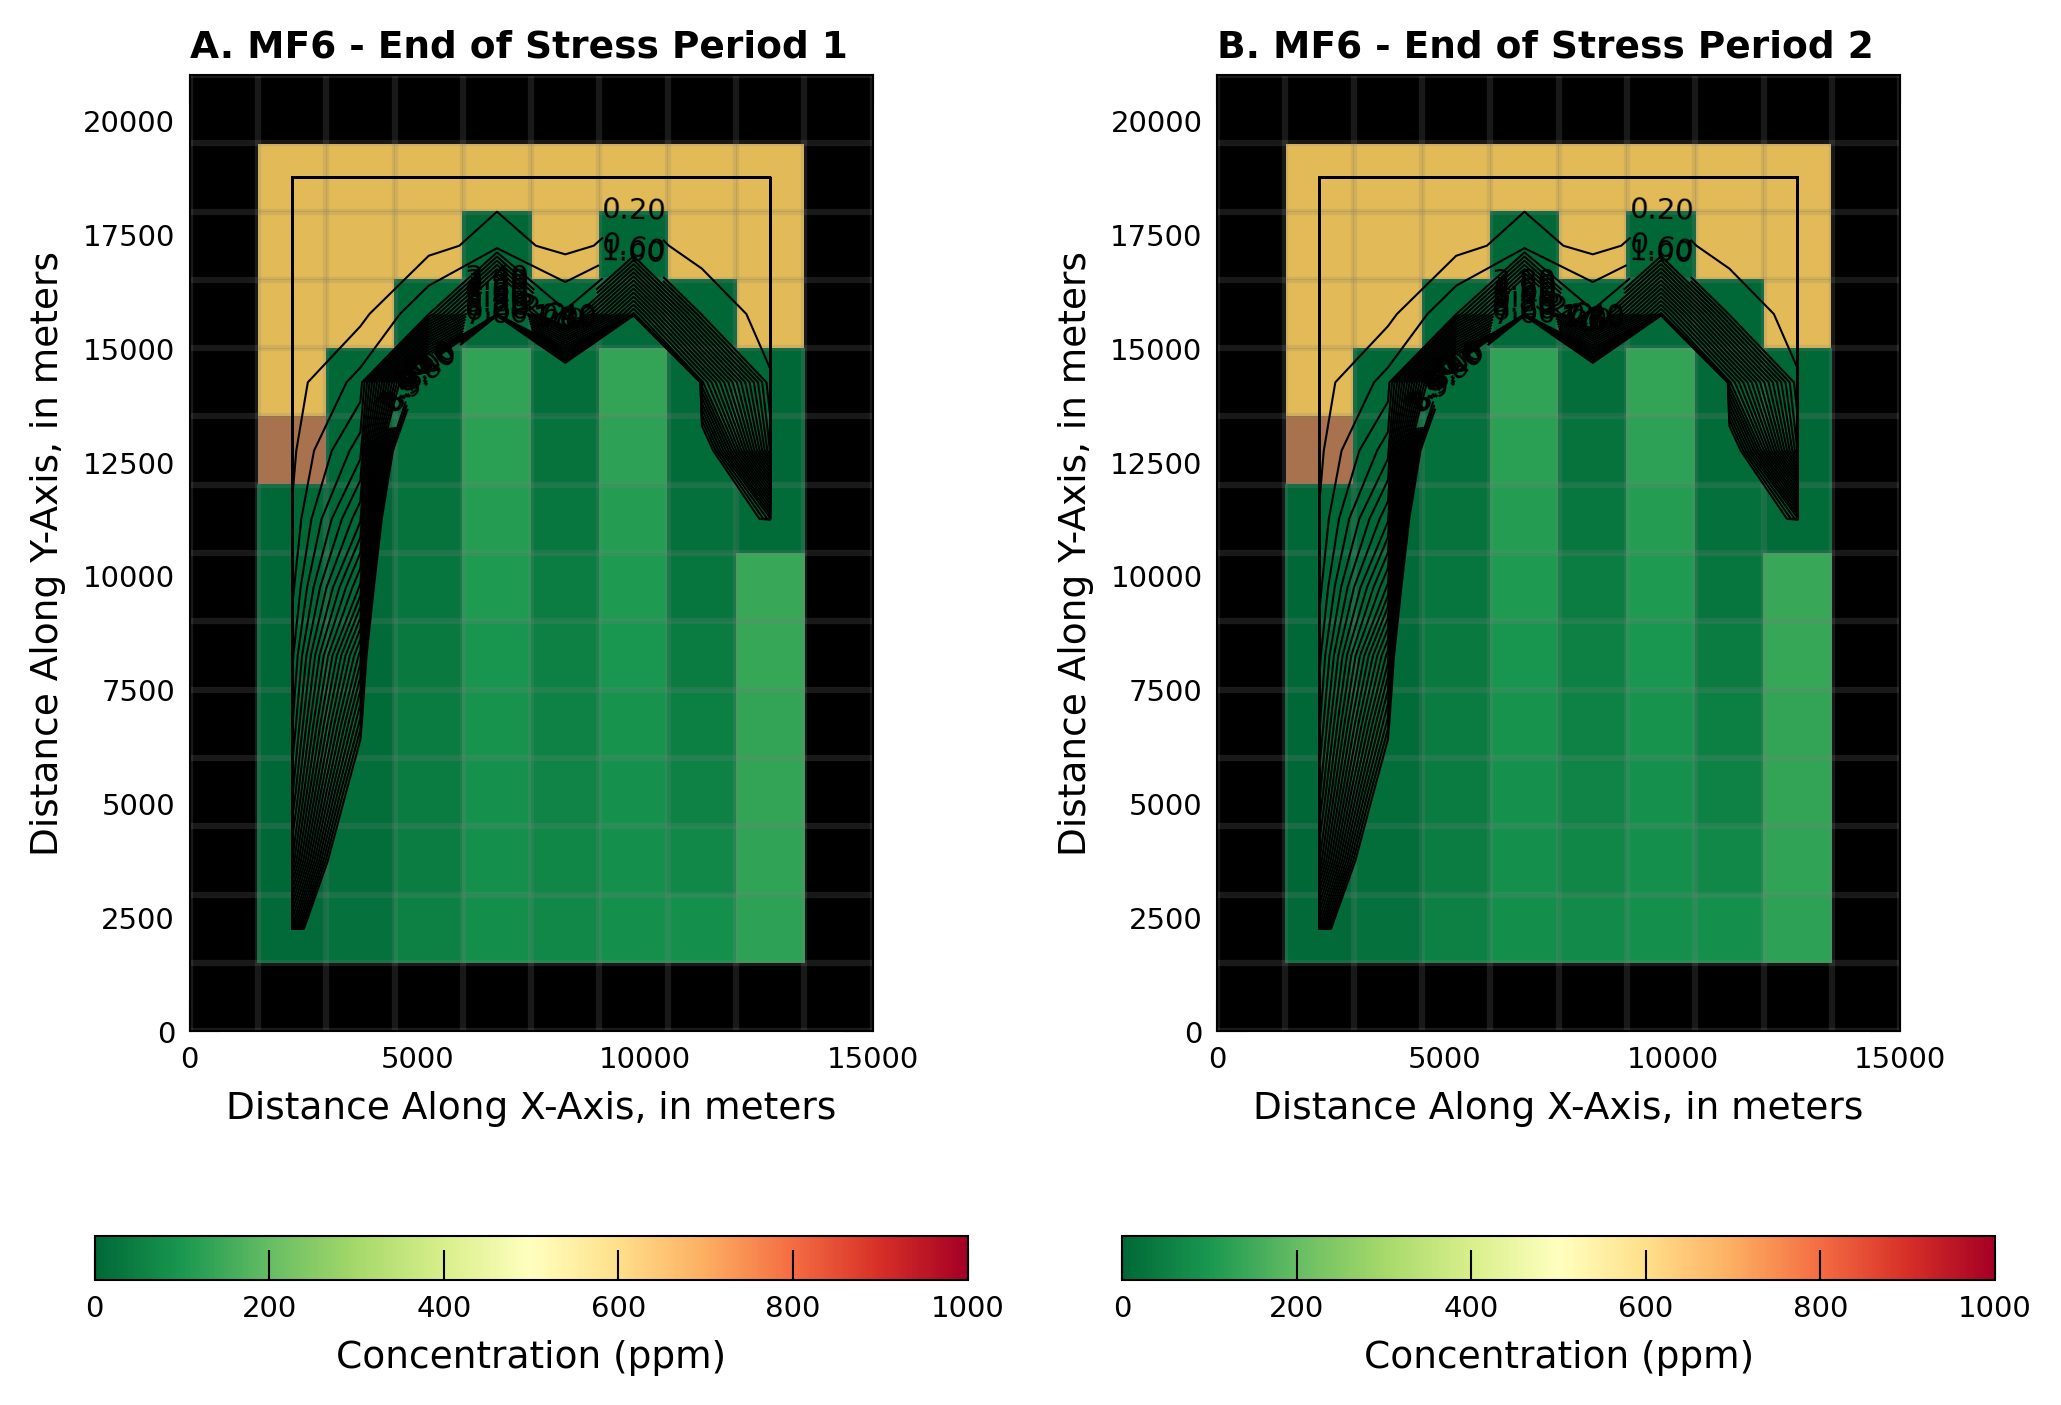

In [178]:
import copy
import matplotlib as mpl
# Figure properties
figure_size = (7, 5)
# Get the MF6 concentration output
gwt = sim.get_model(list(sim.model_names)[1])
ucnobj_mf6 = gwt.output.concentration()
conc_mf6 = ucnobj_mf6.get_alldata()


# Create figure for scenario
with styles.USGSPlot() as fs:
    sim_name = sim.name
    plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]
    levels = np.arange(0.2, 10, 0.4)
    stp_idx = 0  # 0-based (out of 2 possible stress periods)
# Plot after 8 years
    axWasNone = False
#    if ax is None:
    fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
    axWasNone = True
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0],  alpha=1.0, vmin=0, vmax=1000, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 0
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)
    
# second stress period
    stp_idx = 1  # 0-based (out of 2 possible stress periods)
    if axWasNone:
        ax = fig.add_subplot(1, 2, 2, aspect="equal",label = "subplot2")
    cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)
    mm = flopy.plot.PlotMapView(ax=ax, model=gwf)
    colors = ['saddlebrown', 'goldenrod']
    cmap = ListedColormap(colors)
    #mm.plot_array(hk, masked_values=[hk[0, 0, 0]], alpha=0.8, cmap = cmap)
    mm.plot_array(hk, alpha=0.5, cmap = cmap)
    mm.plot_ibound()
    mm.plot_grid(color=".5", alpha=0.2)
    cmap = copy.copy(mpl.cm.get_cmap("RdYlGn_r"))
    #cmap = plt.get_cmap('RdYlGn_r')
    cmap.set_bad(color='none')
    cs = mm.plot_array(cflood[0], alpha=1.0, vmin=0, vmax=1000, cmap = cmap)
# Add a colorbar to the plot
    cbar = plt.colorbar(cs, orientation='horizontal')  # Use orientation='horizontal' if preferred
    cbar.set_label('Concentration (ppm)')  # Replace with appropriate label for your data
    cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels, linewidths=0.5)
    plt.clabel(cs, fmt='%.2f')
    plt.xlabel("Distance Along X-Axis, in meters")
    plt.ylabel("Distance Along Y-Axis, in meters")

    title = "MF6 - End of Stress Period " + str(stp_idx + 1)
# set idx
    idx = 1
    letter = chr(ord("@") + idx + 1)
    styles.heading(letter=letter, heading=title)

In the figures above, the brown rectangle contained within the goldenrod rectangle represent two different horizontal hydraulic conductivities. The goldenrod color represents the conductivity of a medium grain material, $K_1 = 1.474\times 10^{-4}~\frac{m}{sec}$. The brown color represents theconductivity of a fine grain material, $K_2 = 1.474 \times 10^{-7}~\frac{m}{sec}$.

The plume "color map" is overlain on the material property map, and is set to opaque (not transparent).  The color ramp is and inverted GreenYellowRed.  High values render as red, lowest as green.

## Conclusions

Reverse engineered enough to be able to model reasonably complex situations.  The reader should experiment how to get specific discharge out of the model and plot as a "arrow plot" to show flow directions. 